In [1]:
import torch
import torchvision
from diffusers import UNet2DModel
from pipeline_ddpm_custom import DDPMPipelineCustom
from scheduling_rectflow import RectFlowScheduler, RectFlowInverseScheduler
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision.transforms.functional as F
from IPython.display import HTML
from base64 import b64encode

def show_video(video_path):
    video_file = open(video_path, "r+b").read()
    video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
    return HTML(f"""<video width="128" height="128" autoplay loop><source src="{video_url}"></video>""")

# Load the trained model and scheduler
model_dir = "./output/test"
unet = UNet2DModel.from_pretrained(f"{model_dir}/unet")
scheduler_config_path = os.path.join(model_dir, "scheduler", "scheduler_config.json")
scheduler = RectFlowScheduler.from_config(scheduler_config_path)
scheduler_inv = RectFlowInverseScheduler.from_config(scheduler_config_path)
if torch.cuda.is_available():
    unet.to('cuda')

/home/schu23/.conda/envs/writebeau/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'scheduling_rectflow.RectFlowScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)
/data/schu23/mldl/project/Handwriting-Beautification/diffusers/src/diffusers/configuration_utils.py:245: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you w

In [2]:
import math
def lerp(z1, z2, alpha):
    return (1 - alpha) * z1 + alpha * z2
def slerp(z1, z2, alpha):
    theta = torch.acos(torch.sum(z1 * z2) / (torch.norm(z1) * torch.norm(z2)))
    return (
        torch.sin((1 - alpha) * theta) / torch.sin(theta) * z1
        + torch.sin(alpha * theta) / torch.sin(theta) * z2
    )

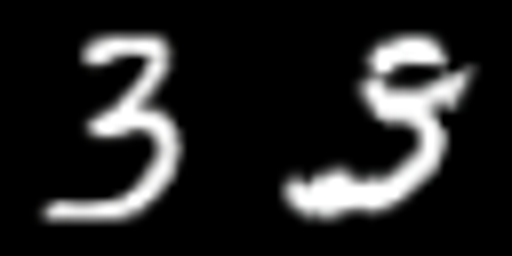

In [3]:
handwrite_img = Image.open('interpolate_samples/handwriting/3/1.png').resize((32, 32))
printed_img = Image.open('interpolate_samples/handwriting/3/3.png').resize((32, 32))
cmb_img = Image.new('RGB', (64, 32))
cmb_img.paste(handwrite_img, (0 ,0))
cmb_img.paste(printed_img, (32 ,0))
cmb_img.resize((512, 256))

In [4]:
# Create the pipeline
pipeline = DDPMPipelineCustom(
    unet=unet,
    scheduler=scheduler,
)
pipeline_inv = DDPMPipelineCustom(
    unet=unet,
    scheduler=scheduler_inv,
)

In [5]:
# Run noise inversion on the given images
images = torch.stack([F.to_tensor(handwrite_img), F.to_tensor(printed_img)]) * 2 - 1
semantic_noise = pipeline_inv(init_noise=images, num_inference_steps=50, output_type='pt').images

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 50.28it/s]


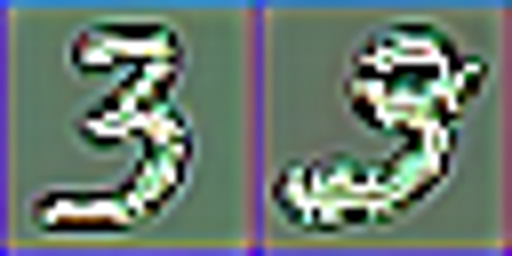

In [6]:
F.to_pil_image(torch.cat([n for n in semantic_noise], dim=-1)).resize((512, 256))

In [7]:
# test reconstruction
images = pipeline(init_noise=semantic_noise * 2 - 1, num_inference_steps=50, output_type='pt').images

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 74.19it/s]


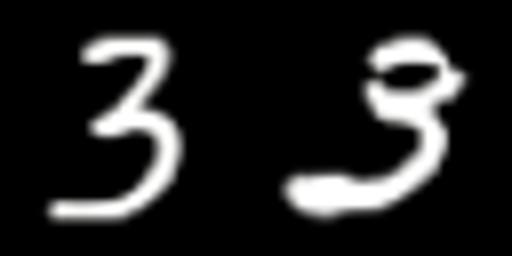

In [8]:
F.to_pil_image(torch.cat([i for i in images], dim=-1)).resize((512, 256))

In [9]:
# interpolation
# semantic_noise = torch.randn_like(semantic_noise).clamp(-1, 1) / 2 + 0.5
interpolant = []
interpolant.append(semantic_noise[0])
for i in range(1, 10):
    interpolant.append(lerp(
        semantic_noise[0],
        semantic_noise[1],
        i / 10,
    ))
interpolant.append(semantic_noise[1])
interpolant = torch.stack(interpolant)

results = pipeline(init_noise=interpolant * 2 - 1, num_inference_steps=50, output_type='pt').images

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.99it/s]


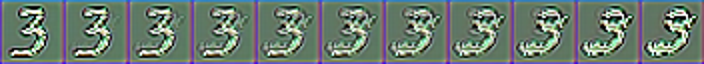

In [10]:
F.to_pil_image(torch.cat([i for i in interpolant], dim=-1)).resize((64 * results.size(0), 64))

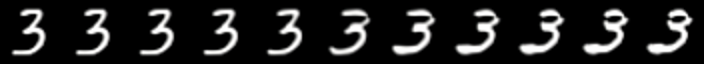

In [11]:
F.to_pil_image(torch.cat([i for i in results], dim=-1)).resize((64 * results.size(0), 64))

In [12]:
# now, increase the sample rate
interpolant = []
interpolant.append(semantic_noise[0])
sr = 50
for i in range(1, sr):
    interpolant.append(lerp(
        semantic_noise[0],
        semantic_noise[1],
        i / sr,
    ))
interpolant.append(semantic_noise[1])
interpolant = torch.stack(interpolant)

results = pipeline(init_noise=interpolant * 2 - 1, num_inference_steps=50, output_type='pt').images

100%|█████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.48it/s]


In [13]:
torchvision.io.write_video(
    '/tmp/tt.mp4',
    results.permute(0, 2, 3, 1) * 255,
    int(sr / 2), # transition in 2s
    options={'crf': '18'})
show_video('/tmp/tt.mp4')